# Testing `calc_rsq()`

We're getting weird results from our iterations, so let's see what's going on. I'm going to run through this code in python2 and python3.

In [1]:
import sys
print (sys.version)

2.7.12 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:42:40) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [2]:
import numpy as np
import os
import pandas as pd
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [103]:
from numpy import isnan, nan, logical_not, logical_or

def exclude_nan(x,y):
    """
    Exclude NaN values if either entry in a pair of vectors has NaN
    """
    idx = logical_not(logical_or(isnan(x), isnan(y)))
    x = x[idx]
    y = y[idx]
    n = len(x)
    return [x, y, n]

def compute_icc(av_corr_mat_A, av_corr_mat_B):
    """
    This function computes the inter-class correlation (ICC) of the
    two classes represented by the x and y numpy vectors.
    """

    inds = np.triu_indices_from(av_corr_mat_B, k=1)
    x = av_corr_mat_A[inds]
    y = av_corr_mat_B[inds]
    
    if all(x == y):
        return 1

    [x, y, n] = exclude_nan(x,y)

    ## Need at least 3 data points to compute this
    if n < 3:
        return nan

    Sx = sum(x); Sy = sum(y);
    Sxx = sum(x*x); Sxy = sum( (x+y)**2 )/2; Syy = sum(y*y)

    fact = ((Sx + Sy)**2)/(n*2)
    SS_tot = Sxx + Syy - fact
    SS_among = Sxy - fact
    SS_error = SS_tot - SS_among

    MS_error = SS_error/n
    MS_among = SS_among/(n-1)
    ICC = (MS_among - MS_error) / (MS_among + MS_error)

    return ICC

In [3]:
def calc_rsq(av_corr_mat_A, av_corr_mat_B):
    """
    From wikipedia: https://en.wikipedia.org/wiki/Coefficient_of_determination
    
    Rsq = 1 - (SSres / SStot)
    
    SSres is calculated as the sum of square errors (where the error
    is the difference between x and y).
    
    SStot is calculated as the total sum of squares in y.
    """
    # Get the data we need
    inds = np.triu_indices_from(av_corr_mat_B, k=1)
    x = av_corr_mat_A[inds]
    y = av_corr_mat_B[inds]
    
    # Calculate the error/residuals
    res = y - x

    SSres = np.sum(res**2)
    
    # Sum up the total error in y
    y_var = y - np.mean(y)
    
    SStot = np.sum(y_var**2)
    
    # R squared
    Rsq = 1 - (SSres/SStot)
    
    return Rsq

## Generate random correlation matrices

In [4]:
df1 = pd.DataFrame(np.random.normal(0, 1, size=(100, 20)))
df2 = pd.DataFrame(np.random.normal(0, 1, size=(100, 20)))
df1corrmat = df1.corr()
df2corrmat = df2.corr()

In [5]:
df1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.427465,1.676209,-0.523225,-0.757328,-1.080402,1.681384,-0.901329,1.069848,-0.900023,0.448092,-0.508891,-0.192381,0.864395,0.008579,-0.026414,2.139157,-3.049636,-1.901518,0.279692,-0.127648
1,2.273053,-1.131997,1.344909,2.246537,-0.439065,-0.657703,0.068282,0.179196,-0.362059,0.536029,-0.296333,-0.406062,-2.308333,1.388697,-0.098028,0.729481,-0.648957,-1.128449,0.541431,-0.908654
2,-0.664216,-0.756577,-0.027574,-1.481897,1.078150,0.269688,-2.436115,-0.630121,0.884774,0.530643,1.236534,0.099381,-0.128011,0.184021,2.135893,0.400071,-0.215624,0.326030,-0.227602,1.153697
3,-0.519272,-0.836833,-0.373189,-1.482146,0.140662,-0.920395,-0.802355,1.361489,-0.186801,1.130677,-4.516005,-2.047634,-1.478475,-0.047936,-0.269501,0.618494,-0.195077,0.350417,-0.072676,0.269115
4,-1.596633,-0.290386,0.141827,0.273876,1.560394,0.274059,-0.158855,0.917433,-0.400278,-0.551394,0.138889,0.201414,0.877448,-0.214035,-0.897336,0.032943,-0.429465,-1.118638,-0.079770,0.245649


In [6]:
df2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.011938,-0.053255,0.397519,2.407409,-1.093463,1.445754,-0.298785,1.066459,-0.298024,0.078510,-0.397998,0.505553,-0.564006,-0.936107,0.896726,0.358632,-0.206431,-0.648920,-0.837507,-1.473312
1,0.227022,1.591562,-0.661655,-1.083018,-1.060560,0.971536,-0.535551,-0.649059,0.703308,-0.397899,1.466003,1.336114,1.013038,1.833532,-0.685096,0.699467,-0.922580,0.735426,-1.154396,-0.734870
2,0.960593,-0.095154,-0.400449,1.862249,-0.533184,-0.359374,-1.914226,0.956190,1.053026,-1.004380,-0.821458,2.118752,-1.653876,0.102839,-0.015470,-0.168857,-1.663059,-0.741635,0.948794,0.335963
3,0.339071,0.112771,0.795608,1.280650,-1.040808,-0.398791,0.562161,-1.065787,-0.533621,-0.192391,1.405663,1.161486,1.235782,-0.025392,-0.781738,0.361130,1.627280,-1.010542,-0.776954,0.923010
4,1.798614,0.484135,-1.075847,-0.471970,0.219090,-1.064341,-1.089752,-0.919436,0.287245,-0.632272,1.352610,-1.441191,-1.326823,2.291114,0.478383,-1.275641,-1.151039,0.764605,-1.012965,0.285253


In [7]:
df1corrmat.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.000000,-0.143179,-0.004157,0.092112,0.058043,-0.086843,0.091421,0.061989,-0.041253,0.100913,-0.178138,0.046844,-0.082510,0.089326,-0.174752,0.039182,-0.092636,0.036105,0.142862,-0.061245
1,-0.143179,1.000000,0.158269,-0.051211,-0.041989,0.079460,0.181167,-0.005152,-0.104973,-0.031888,0.066835,0.173336,0.037638,0.029786,0.064324,0.006272,0.146510,0.001812,-0.137590,-0.141431
2,-0.004157,0.158269,1.000000,0.013060,0.112813,-0.076963,-0.015136,-0.008006,0.095416,-0.050181,0.114141,0.027223,-0.039129,-0.039650,0.034778,-0.101395,-0.008048,0.025642,-0.112998,0.047343
3,0.092112,-0.051211,0.013060,1.000000,-0.000914,-0.233160,0.053282,-0.197761,-0.028955,-0.152730,-0.193451,0.059678,-0.063049,0.062169,0.072666,-0.055307,-0.095264,-0.058562,0.014544,-0.158877
4,0.058043,-0.041989,0.112813,-0.000914,1.000000,0.013930,-0.119157,-0.003328,0.026933,0.089406,0.036462,-0.038962,-0.046395,-0.111320,0.004759,0.101196,0.052046,-0.001888,0.055933,-0.029475


In [8]:
df2corrmat.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.000000,0.032331,-0.003926,0.010697,0.023385,-0.024654,0.124844,0.032305,0.036052,0.054127,0.076383,0.118299,0.010689,0.292114,0.019970,-0.117152,0.078136,0.252936,-0.066023,-0.029354
1,0.032331,1.000000,0.066007,-0.040074,0.146434,0.034358,0.180126,0.077691,-0.056560,-0.177011,-0.044257,0.057833,-0.130250,-0.087217,0.025901,0.070715,-0.021382,0.057469,-0.195865,-0.107826
2,-0.003926,0.066007,1.000000,0.223490,0.050373,-0.038791,0.073610,-0.069055,0.043481,-0.018479,-0.040921,0.016055,-0.070506,0.035386,0.020248,0.057362,0.015123,-0.091649,-0.131668,-0.105548
3,0.010697,-0.040074,0.223490,1.000000,0.018116,0.098340,0.064419,0.014682,-0.002317,0.041460,0.040270,0.155850,0.031800,0.074210,0.142804,-0.013881,0.103719,-0.168511,-0.081880,-0.074093
4,0.023385,0.146434,0.050373,0.018116,1.000000,0.056364,0.059839,-0.088610,-0.058504,0.092035,0.005883,0.017900,-0.163475,-0.102803,0.079794,0.087457,-0.043869,-0.081234,0.320647,0.040095


## Calculate $R^2$ from random matrices

In [9]:
calc_rsq(df1.corr().as_matrix(), df2.corr().as_matrix())

-0.81041607780271097

Now let's walk through the code above to see what it's doing.

In [10]:
inds = np.triu_indices_from( df2.corr().as_matrix(), k=1)
inds

(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
         2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
         3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,
         7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,
         9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,
        10, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 13,
        13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 16, 16, 16,
        17, 17, 18]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14

In [11]:
x =  df1.corr().as_matrix()[inds]
y =  df2.corr().as_matrix()[inds]

In [12]:
print(str(df1.corr().shape) + " matrix gives an upper triangle with length " + str((20*(20-1))/2))

(20, 20) matrix gives an upper triangle with length 190


`df.corr()` is a $20\times 20$ matrix, so getting the upper triangle should give us $\frac{20\cdot (20-1)}{2}=190$ cells in the upper triangle.

In [13]:
len(x)

190

Yay, we get what we expect!

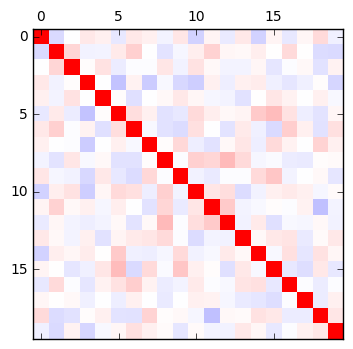

In [14]:
plt.matshow(df1.corr(), vmin=-1, vmax=1, cmap='bwr')

In [15]:
df1.corr().round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.00,-0.14,-0.00,0.09,0.06,-0.09,0.09,0.06,-0.04,0.10,-0.18,0.05,-0.08,0.09,-0.17,0.04,-0.09,0.04,0.14,-0.06
1,-0.14,1.00,0.16,-0.05,-0.04,0.08,0.18,-0.01,-0.10,-0.03,0.07,0.17,0.04,0.03,0.06,0.01,0.15,0.00,-0.14,-0.14
2,-0.00,0.16,1.00,0.01,0.11,-0.08,-0.02,-0.01,0.10,-0.05,0.11,0.03,-0.04,-0.04,0.03,-0.10,-0.01,0.03,-0.11,0.05
3,0.09,-0.05,0.01,1.00,-0.00,-0.23,0.05,-0.20,-0.03,-0.15,-0.19,0.06,-0.06,0.06,0.07,-0.06,-0.10,-0.06,0.01,-0.16
4,0.06,-0.04,0.11,-0.00,1.00,0.01,-0.12,-0.00,0.03,0.09,0.04,-0.04,-0.05,-0.11,0.00,0.10,0.05,-0.00,0.06,-0.03
5,-0.09,0.08,-0.08,-0.23,0.01,1.00,0.13,0.06,-0.12,-0.09,0.14,0.07,0.03,0.04,0.21,0.27,0.12,-0.06,-0.10,0.03
6,0.09,0.18,-0.02,0.05,-0.12,0.13,1.00,-0.03,-0.12,-0.14,0.12,-0.00,-0.11,0.08,-0.06,-0.14,0.19,0.06,-0.11,0.12
7,0.06,-0.01,-0.01,-0.20,-0.00,0.06,-0.03,1.00,0.01,0.15,-0.06,-0.11,0.03,0.10,-0.06,0.15,0.05,-0.00,0.17,0.06
8,-0.04,-0.10,0.10,-0.03,0.03,-0.12,-0.12,0.01,1.00,-0.01,0.18,0.16,0.27,0.14,-0.03,-0.02,-0.07,-0.08,0.01,0.02
9,0.10,-0.03,-0.05,-0.15,0.09,-0.09,-0.14,0.15,-0.01,1.00,-0.05,-0.08,-0.01,-0.01,0.15,0.23,-0.04,-0.00,0.03,-0.10


In [16]:
x.round(2)

array([-0.14, -0.  ,  0.09,  0.06, -0.09,  0.09,  0.06, -0.04,  0.1 ,
       -0.18,  0.05, -0.08,  0.09, -0.17,  0.04, -0.09,  0.04,  0.14,
       -0.06,  0.16, -0.05, -0.04,  0.08,  0.18, -0.01, -0.1 , -0.03,
        0.07,  0.17,  0.04,  0.03,  0.06,  0.01,  0.15,  0.  , -0.14,
       -0.14,  0.01,  0.11, -0.08, -0.02, -0.01,  0.1 , -0.05,  0.11,
        0.03, -0.04, -0.04,  0.03, -0.1 , -0.01,  0.03, -0.11,  0.05,
       -0.  , -0.23,  0.05, -0.2 , -0.03, -0.15, -0.19,  0.06, -0.06,
        0.06,  0.07, -0.06, -0.1 , -0.06,  0.01, -0.16,  0.01, -0.12,
       -0.  ,  0.03,  0.09,  0.04, -0.04, -0.05, -0.11,  0.  ,  0.1 ,
        0.05, -0.  ,  0.06, -0.03,  0.13,  0.06, -0.12, -0.09,  0.14,
        0.07,  0.03,  0.04,  0.21,  0.27,  0.12, -0.06, -0.1 ,  0.03,
       -0.03, -0.12, -0.14,  0.12, -0.  , -0.11,  0.08, -0.06, -0.14,
        0.19,  0.06, -0.11,  0.12,  0.01,  0.15, -0.06, -0.11,  0.03,
        0.1 , -0.06,  0.15,  0.05, -0.  ,  0.17,  0.06, -0.01,  0.18,
        0.16,  0.27,

These also match, so that's good. Time to walk through the $R^2$ calculation.

In [17]:
res = y - x
res

array([  1.75510132e-01,   2.31298162e-04,  -8.14150539e-02,
        -3.46583632e-02,   6.21891215e-02,   3.34232477e-02,
        -2.96840863e-02,   7.73045985e-02,  -4.67861432e-02,
         2.54521027e-01,   7.14550557e-02,   9.31997471e-02,
         2.02788276e-01,   1.94721395e-01,  -1.56334670e-01,
         1.70772563e-01,   2.16831513e-01,  -2.08884605e-01,
         3.18901261e-02,  -9.22619427e-02,   1.11374349e-02,
         1.88423019e-01,  -4.51012228e-02,  -1.04102371e-03,
         8.28427947e-02,   4.84129915e-02,  -1.45122464e-01,
        -1.11091949e-01,  -1.15503126e-01,  -1.67887893e-01,
        -1.17002783e-01,  -3.84236840e-02,   6.44429830e-02,
        -1.67891670e-01,   5.56560226e-02,  -5.82746468e-02,
         3.36052852e-02,   2.10430836e-01,  -6.24396663e-02,
         3.81710757e-02,   8.87460401e-02,  -6.10488272e-02,
        -5.19350424e-02,   3.17023480e-02,  -1.55062134e-01,
        -1.11676972e-02,  -3.13766143e-02,   7.50364433e-02,
        -1.45300509e-02,

In [18]:
SSres = np.sum(res**2)
SSres

3.419522848342671

In [19]:
# Sum up the total error in y
y_var = y - np.mean(y)
y_var

array([ 0.02713863, -0.00911822,  0.00550398,  0.01819206, -0.02984674,
        0.11965146,  0.02711252,  0.03085925,  0.04893454,  0.07119002,
        0.11310616,  0.00549684,  0.28692166,  0.01477701, -0.12234479,
        0.07294382,  0.24774361, -0.07121571, -0.03454704,  0.06081456,
       -0.04526649,  0.14124173,  0.02916583,  0.17493333,  0.07249814,
       -0.06175295, -0.18220324, -0.04944979,  0.05264005, -0.13544282,
       -0.09240985,  0.02070796,  0.06552199, -0.02657461,  0.0522759 ,
       -0.20105716, -0.11301832,  0.21829786,  0.04518053, -0.04398406,
        0.06841774, -0.07424749,  0.03828806, -0.02367114, -0.04611335,
        0.0108626 , -0.07569864,  0.03019339,  0.01505518,  0.052169  ,
        0.00993062, -0.09684115, -0.13686098, -0.11074047,  0.01292328,
        0.09314778,  0.05922684,  0.00948926, -0.00750984,  0.03626752,
        0.03507741,  0.1506576 ,  0.02660718,  0.06901706,  0.137611  ,
       -0.01907344,  0.09852604, -0.17370385, -0.0870731 , -0.07

In [20]:
SStot = np.sum(y_var**2)
SStot

1.8888049494638388

In [21]:
# R squared
Rsq = 1 - (SSres/SStot)
Rsq

-0.81041607780271097

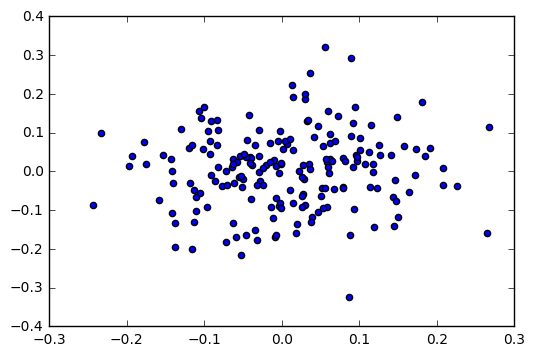

In [22]:
plt.scatter(x, y)

## Conclusion

Python 3: This works as expected, but we had to use `as_matrix()` to get it to not error in `calc_rsq()`.
Python 2: This works as expected, but we had to use `as_matrix()` to get it to not error in `calc_rsq()`.

# Real Data

In [23]:
behav_data_f = 'Phenotypic_V1_0b_preprocessed1.csv'

In [24]:
df = pd.read_csv(behav_data_f)
df = df.loc[df['func_perc_fd'].notnull(), :]
df = df.loc[df['FILE_ID']!='no_filename', :]
df['AGE_YRS'] = np.floor(df['AGE_AT_SCAN'])
df.head()

,Unnamed: 0,Unnamed: 0.1,SUB_ID,X,subject,SITE_ID,FILE_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,...,qc_anat_rater_2,qc_anat_notes_rater_2,qc_func_rater_2,qc_func_notes_rater_2,qc_anat_rater_3,qc_anat_notes_rater_3,qc_func_rater_3,qc_func_notes_rater_3,SUB_IN_SMP,AGE_YRS
1,1,2,50003,2,50003,PITT,Pitt_0050003,1,1,24.45,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1,24.0
2,2,3,50004,3,50004,PITT,Pitt_0050004,1,1,19.09,...,OK,NaN,OK,NaN,OK,NaN,OK,NaN,1,19.0
3,3,4,50005,4,50005,PITT,Pitt_0050005,1,1,13.73,...,OK,NaN,maybe,ic-parietal-cerebellum,OK,NaN,OK,NaN,0,13.0
4,4,5,50006,5,50006,PITT,Pitt_0050006,1,1,13.37,...,OK,NaN,maybe,ic-parietal slight,OK,NaN,OK,NaN,1,13.0
5,5,6,50007,6,50007,PITT,Pitt_0050007,1,1,17.78,...,OK,NaN,maybe,ic-cerebellum_temporal_lob,OK,NaN,OK,NaN,1,17.0


In [25]:
nsubs = 100
start1 = 0
start2 = 100
for i, (sub, f_id) in enumerate(df.loc[start1:(start1+nsubs),['SUB_ID', 'FILE_ID']].values):
    #read each subjects aal roi time series files
    ts_df = pd.read_table('DATA/{}_rois_aal.1D'.format(f_id))

    #create a correlation matrix from the roi all time series files
    corr_mat = ts_df.corr()

    #for the first subject, add a correlation matrix of zeros that is the same dimensions as the aal roi-roi matrix
    if i == 0:
        all_corr_mat1 = np.empty([corr_mat.shape[0], corr_mat.shape[1], nsubs])

    #now add the correlation matrix you just created for each subject to the all_corr_mat matrix (3D)
    all_corr_mat1[:, :, i] = corr_mat

#create the mean correlation matrix (ignore nas - sometime there are some...)
av_corr_mat1 = np.nanmean(all_corr_mat1, axis=2)

for i, (sub, f_id) in enumerate(df.loc[start2:(start2+nsubs),['SUB_ID', 'FILE_ID']].values):
    #read each subjects aal roi time series files
    ts_df = pd.read_table('DATA/{}_rois_aal.1D'.format(f_id))

    #create a correlation matrix from the roi all time series files
    corr_mat = ts_df.corr()

    #for the first subject, add a correlation matrix of zeros that is the same dimensions as the aal roi-roi matrix
    if i == 0:
        all_corr_mat2 = np.empty([corr_mat.shape[0], corr_mat.shape[1], nsubs])

    #now add the correlation matrix you just created for each subject to the all_corr_mat matrix (3D)
    all_corr_mat2[:, :, i] = corr_mat

#create the mean correlation matrix (ignore nas - sometime there are some...)
av_corr_mat2 = np.nanmean(all_corr_mat2, axis=2)

In [26]:
[all_corr_mat1.shape, all_corr_mat2.shape]

[(116, 116, 100), (116, 116, 100)]

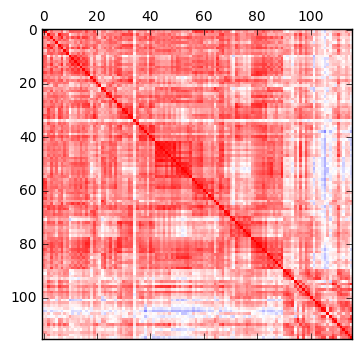

In [27]:
plt.matshow(all_corr_mat1[:,:,0], vmin=-1, vmax=1, cmap='bwr')

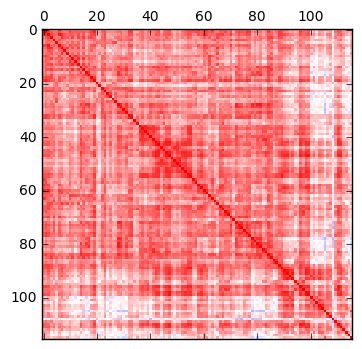

In [28]:
plt.matshow(all_corr_mat1[:,:,9], vmin=-1, vmax=1, cmap='bwr')

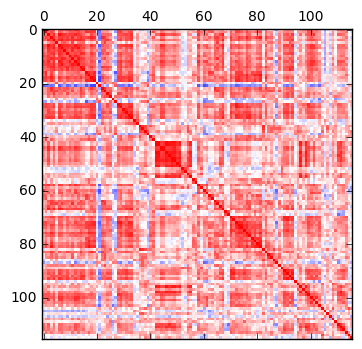

In [29]:
plt.matshow(all_corr_mat2[:,:,0], vmin=-1, vmax=1, cmap='bwr')

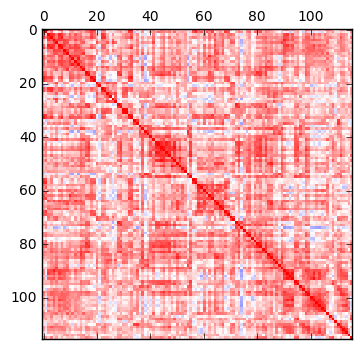

In [30]:
plt.matshow(all_corr_mat2[:,:,9], vmin=-1, vmax=1, cmap='bwr')

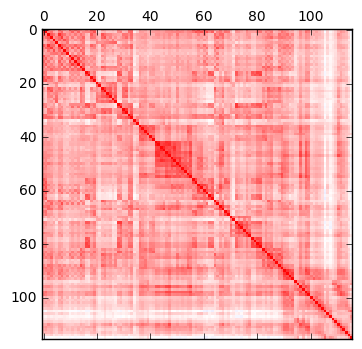

In [31]:
plt.matshow(av_corr_mat1, vmin=-1, vmax=1, cmap='bwr')

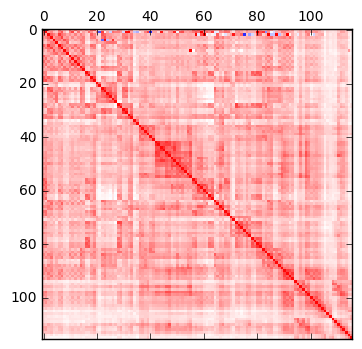

In [32]:
plt.matshow(av_corr_mat2, vmin=-1, vmax=1, cmap='bwr')

In [33]:
np.fill_diagonal(av_corr_mat1, 0)
np.fill_diagonal(av_corr_mat2, 0)

np.round([(av_corr_mat1.min(), av_corr_mat1.max()), (av_corr_mat2.min(), av_corr_mat2.max())])

array([[ -0.00000000e+000,   1.00000000e+000],
       [ -1.00000000e+000,   2.15223028e+135]])

In [34]:
np.fill_diagonal(all_corr_mat1[:,:,89], 0)
np.fill_diagonal(all_corr_mat1[:,:,66], 0)

np.round([(all_corr_mat1[:,:,89].min(), all_corr_mat1[:,:,89].max()), (all_corr_mat1[:,:,66].min(), all_corr_mat1[:,:,66].max())], 2)

array([[-0.27,  0.94],
       [-0.53,  0.93]])

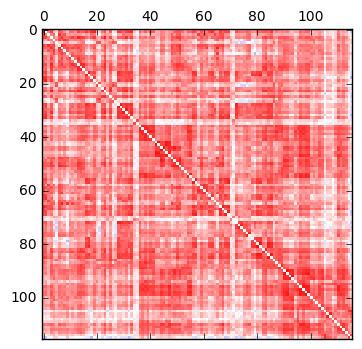

In [35]:
plt.matshow(all_corr_mat1[:,:,89], vmin=-1, vmax=1, cmap='bwr')

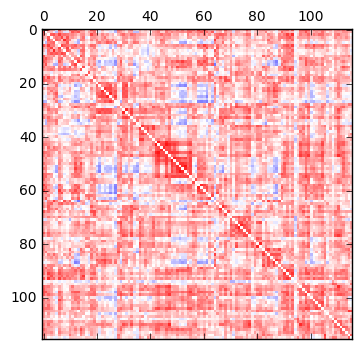

In [36]:
plt.matshow(all_corr_mat1[:,:,66], vmin=-1, vmax=1, cmap='bwr')

In [37]:
calc_rsq(av_corr_mat1, av_corr_mat2)

-0.00014994751836905351

Apparently we need to Fisher *z* transform them, which is equivalent to the arctanh function.

In [38]:
nsubs = 100
start1 = 0
start2 = 100
for i, (sub, f_id) in enumerate(df.loc[start1:(start1+nsubs),['SUB_ID', 'FILE_ID']].values):
    #read each subjects aal roi time series files
    ts_df = pd.read_table('DATA/{}_rois_aal.1D'.format(f_id))

    #create a correlation matrix from the roi all time series files
    corr_mat_r = ts_df.corr()
    corr_mat_z = np.arctanh(corr_mat_r)

    #for the first subject, add a correlation matrix of zeros that is the same dimensions as the aal roi-roi matrix
    if i == 0:
        all_corr_mat1_z = np.zeros([corr_mat_z.shape[0], corr_mat_z.shape[1], nsubs])

    #now add the correlation matrix you just created for each subject to the all_corr_mat matrix (3D)
    all_corr_mat1_z[:, :, i] = corr_mat_z

#create the mean correlation matrix (ignore nas - sometime there are some...)
av_corr_mat1_z = np.nanmean(all_corr_mat1_z, axis=2)

for i, (sub, f_id) in enumerate(df.loc[start2:(start2+nsubs),['SUB_ID', 'FILE_ID']].values):
    #read each subjects aal roi time series files
    ts_df = pd.read_table('DATA/{}_rois_aal.1D'.format(f_id))

    #create a correlation matrix from the roi all time series files
    corr_mat_r = ts_df.corr()
    corr_mat_z = np.arctanh(corr_mat_r)
    
    #for the first subject, add a correlation matrix of zeros that is the same dimensions as the aal roi-roi matrix
    if i == 0:
        all_corr_mat2_z = np.zeros([corr_mat_z.shape[0], corr_mat_z.shape[1], nsubs])

    #now add the correlation matrix you just created for each subject to the all_corr_mat matrix (3D)
    all_corr_mat2_z[:, :, i] = corr_mat_z

#create the mean correlation matrix (ignore nas - sometime there are some...)
av_corr_mat2_z = np.nanmean(all_corr_mat2_z, axis=2)

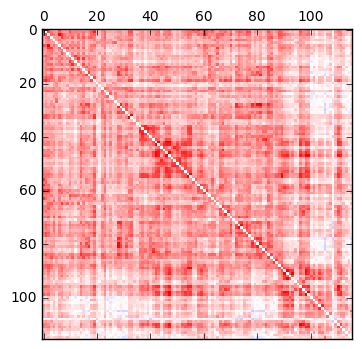

In [39]:
plt.matshow(all_corr_mat1_z[:,:,9], vmin=-1.5, vmax=1.5, cmap='bwr')

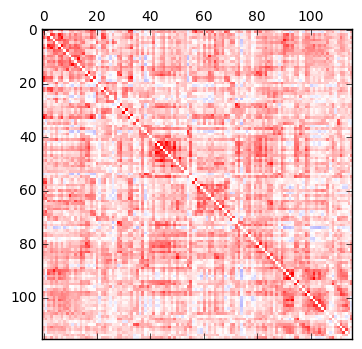

In [40]:
plt.matshow(all_corr_mat2_z[:,:,9], vmin=-1.5, vmax=1.5, cmap='bwr')

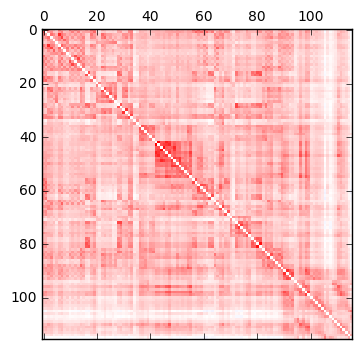

In [41]:
plt.matshow(av_corr_mat1_z, vmin=-1.5, vmax=1.5, cmap='bwr')

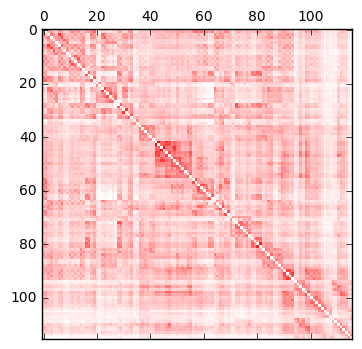

In [42]:
plt.matshow(av_corr_mat2_z, vmin=-1.5, vmax=1.5, cmap='bwr')

In [43]:
np.fill_diagonal(av_corr_mat1_z, 0)
np.fill_diagonal(av_corr_mat2_z, 0)

np.round([(av_corr_mat1_z.min(), av_corr_mat1_z.max()), (av_corr_mat2_z.min(), av_corr_mat2_z.max())],4)

array([[-0.0752,  1.6009],
       [-0.0198,  1.4522]])

In [44]:
calc_rsq(av_corr_mat1_z, av_corr_mat2_z)

0.82211375388083741

In [64]:
calc_rsq(np.random.normal(0,.0001, size=(190,190)), np.random.normal(0,.0001, size=(190,190)))

-1.0163295900871834

In [86]:
covmat = np.zeros((190, 190))
means = np.zeros(190)
np.fill_diagonal(covmat, 1)
datas1=pd.DataFrame(data=np.random.multivariate_normal(means, covmat, size=100))
datas2=pd.DataFrame(data=np.random.multivariate_normal(means, covmat, size=100))
datas1.shape

(100, 190)

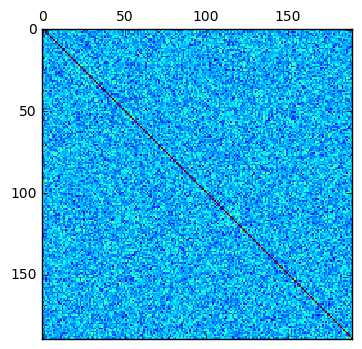

In [87]:
plt.matshow(datas1.corr())

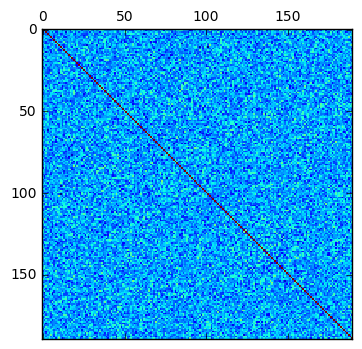

In [88]:
plt.matshow(datas2.corr())

In [99]:
calc_rsq(datas1.corr().as_matrix(), datas2.corr().as_matrix())

-1.0021894152315931

## Try out the new icc function too

In [104]:
compute_icc(datas1.corr().as_matrix(), datas2.corr().as_matrix())

0.0072004965743832292

In [105]:
compute_icc(av_corr_mat1_z, av_corr_mat2_z)

0.92101435582748625